## Simulation-based inference of spectral graph model frequency spectrum with `spectrome`: Usage example

### Import modules with respective paths

In [2]:
# this path append is for binder only
import sys
sys.path.append("../../")

#generic modules
import matplotlib as mpl
import matplotlib.colors

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd 
import pickle as pkl
import random
from scipy import stats
import seaborn as sns
import time

#spectrome modules
from spectrome.forward import runforward
from spectrome.utils import functions, path
from spectrome.brain import Brain

# IO
import scipy.io as sio

# sbi
import torch
import sbi.utils as utils
from sbi.inference.base import infer

# Analysis
import scipy.spatial.distance
from sklearn.model_selection import ParameterGrid
from scipy.interpolate import interp1d
from scipy.signal import lfilter, firls, decimate
from scipy.stats import gaussian_kde
from scipy import stats

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

# fooof modules
import fooof
from fooof import FOOOF

# display settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    filtered_av_db = run_SGM_model(params)
#     summstats = torch.as_tensor(calculate_summary_statistics(obs))
    summstats = calculate_summary_statistics(filtered_av_db['data'])
    return summstats

def run_SGM_model(params):
    params = np.asarray(params)
    states = SGM_simulator(params.reshape(1, -1))
    return dict(data=states)

def get_FOOOF(spectrum, fvec, freq_range):
    fm = FOOOF(verbose=False)
    fm.fit(fvec, spectrum, freq_range)
    aperiodic_exp = fm.aperiodic_params_[1]
    aperiodic_fit_spectrum = fm._ap_fit
    return aperiodic_exp, aperiodic_fit_spectrum


def calculate_summary_statistics(spectrum_db, max_freq_idc=109):
    fmin = 0.5 # 2Hz - 45Hz signal range, filter for this with hbp
    fmax = 55
    num_freqs=110
    freq_range = [0.5, fmax] # can't use 0.5 as fmin b/c it is freq bin size with Welch

    fvec = np.linspace(fmin,fmax,num_freqs) # np.linspace(0.8, 40, 197)
    
    spectrum_db -= np.max(spectrum_db) # normalize to zero   
    spectrum_slope = (np.max(spectrum_db) - np.min(spectrum_db))/fvec[max_freq_idc]
    spectrum_diff = np.diff(spectrum_db[1:max_freq_idc])
    
    max_freq_idc=30
    decimated_spectra = spectrum_db[1:max_freq_idc]
    
#     summstats = torch.as_tensor(np.hstack([spectrum_db, decimated_spectra]))
    summstats = torch.as_tensor(decimated_spectra)
    
    return summstats


def scale_spectra(spectrum):
    return spectrum - np.max(spectrum)


def SGM_simulator(brain_params):

    # Params
    lpf = np.array([1, 2, 5, 2, 1])
    lpf = lpf/np.sum(lpf)
    fmin = 0.5 # 2Hz - 45Hz signal range, filter for this with hbp
    fmax = 55
    num_freqs=110
    fvec = np.linspace(fmin,fmax,num_freqs) # np.linspace(0.8, 40, 197)
    
    new_brain = Brain.Brain()

    hcp_dir = path.get_data_path() # connectome information is in /data/ dir
#     new_brain.add_connectome(hcp_dir, conmat_in='neonate/neonate_weighted_fibercount.csv', dmat_in='neonate/neonate_fiberlength.csv') # Use default files in /data/

    # Adjust parameters
    new_brain.connectome = new_brain.connectome
    new_brain.distance_matrix = new_brain.distance_matrix

    # Some re-ordering and normalizing (reduced):
    new_brain.reorder_neonatal_connectome(new_brain.connectome, new_brain.distance_matrix)
    new_brain.bi_symmetric_c()
    new_brain.reduce_extreme_dir()

    new_brain.ntf_params = {
            'tau_e': brain_params[0, 0], 
            'tau_i': brain_params[0, 1],
            'alpha': brain_params[0, 2], 
            'speed': brain_params[0, 3], 
            'gei': brain_params[0, 4], 
            'gii': brain_params[0, 5],
            'tauC': 0.02 # 
            }
    
    model_spectrum, freq_response, eigvalues, eigvectors = runforward.run_local_coupling_forward(new_brain, new_brain.ntf_params, fvec)

    filtered_av = 0
    num_traces = 0

    for g in range(len(model_spectrum)):
        spectrum = np.abs(model_spectrum[g,:])
        filtered = np.convolve(spectrum, lpf, 'same')
        filtered_av += filtered
        num_traces += 1

    filtered_av /= num_traces
    filtered_av_db = functions.mag2db(filtered_av)
    filtered_av_db = scale_spectra(filtered_av_db)
    
    del new_brain

    return filtered_av_db

def get_limits(prior_min, prior_max):
    limits = []
    for mi, ma in zip(prior_min, prior_max):
        limits.append([mi, ma])
    return limits

## Define SGM priors

In [4]:
prior_min = [0.01, 0.01, .1, 0.1, 5., 5.]
prior_max = [0.01, 0.01, 1., 5, 13., 13.]

prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

In [9]:
## Train Neural Density Estimator

In [7]:
posterior = infer(simulation_wrapper, prior, method='SNPE', num_simulations=100000, num_workers=7)   

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Neural network successfully converged after 372 epochs.


# Generate Infant (<1 yo), Toddler (1-3 yo), and Children (>3 yo) Posteriors

In [13]:
# Parameters
df_kids = pd.read_csv('../../../eegPedsSpectra/csv/sessions.csv')
exp_folder = '../../../eegPedsSpectra/results/psds/' # export folder
freqs_file_name = '%s/%s_freqs.npy' % (exp_folder, df_kids.index[0])


	Skipping! A00054666001  because of noise
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
	Skipping! A00056762001  because of noise


../../spectrome/utils/functions.py:17: RuntimeWarning: divide by zero encountered in log10
  dby = 20 * np.log10(y)
<ipython-input-3-f8a2beb4db94>:55: RuntimeWarning: invalid value encountered in subtract
  return spectrum - np.max(spectrum)


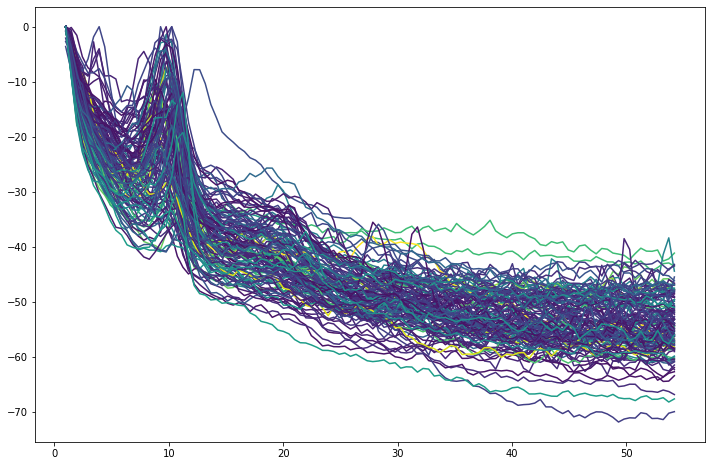

In [44]:
max_freq_idx = 110
plt.figure(figsize=(12, 8))      

cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin=np.min(df_kids.age), vmax=np.max(df_kids.age))

kids_psd_dict = {}
for subject in df_kids.subject_id:

    #     print(subject)
    psd_file_name = '%s/%s_psd.npy' % (exp_folder, subject)
    freqs_file_name = '%s/%s_freqs.npy' % (exp_folder, subject)

    psd = np.load(psd_file_name)
    psd = psd.mean(axis=(0,1))
    freqs = np.load(freqs_file_name)

    psd_db = functions.mag2db(psd)
    psd_db =  scale_spectra(psd_db)
    psd=psd_db
    if subject == 'A00054766016': # Skip this subject due to NaN's in PSD
        continue
    max_idx = np.argmax(psd[10:max_freq_idx])
    
    # Skip subjects with excessive EMG artifact
    if freqs[max_idx] > 15:
        print('\tSkipping!', subject,' because of noise')
        df_kids = df_kids.drop(df_kids[df_kids.subject_id == subject].index)
        continue
    
    kids_psd_dict[str(subject)] = [freqs[:max_freq_idx], psd[:max_freq_idx]]
    
    
    age = df_kids.loc[df_kids.subject_id == subject].age.values[0]

    plt.plot(freqs[:max_freq_idx], psd[:max_freq_idx], color=cmap(norm(age)))
    

    
# plt.yscale('log')
# plt.xscale('log')
plt.show();

In [16]:
# Calculate kid posteriors

start_time = time.time()

kid_priors = {}
for subject, vals in kids_psd_dict.items():

    freqs, psd = kids_psd_dict[subject]
    
    if subject == 'A00054766016':
        print('Skipping:', subject, 'broken')
        continue
        
    observation_summary_statistics = calculate_summary_statistics(psd)
    kid_priors[subject] = posterior.sample((1000,), x=observation_summary_statistics, show_progress_bars=0, sample_with_mcmc=1)    
    
    with open("kid_priors.pkl", 'wb') as f:
        pkl.dump(kid_priors,f)
    print("subject: %s, %.2f minutes" % (subject, (time.time() - start_time)/60))

subject: A00051826001, 11.64 minutes
subject: A00054930001, 21.83 minutes
subject: A00054753001, 33.66 minutes
subject: A00055024001, 45.24 minutes
subject: A00058596001, 61.62 minutes
subject: A00054535001, 71.72 minutes
subject: A00055077001, 84.35 minutes
subject: A00051886001, 96.67 minutes
subject: A00055628002, 110.88 minutes
subject: A00056002001, 123.19 minutes
subject: A00054907001, 134.14 minutes
subject: A00055424001, 146.18 minutes
subject: A00053375001, 164.29 minutes
subject: A00053375003, 177.69 minutes
subject: A00053375002, 192.25 minutes
subject: A00055085001, 202.72 minutes
subject: A00062435001, 215.86 minutes
subject: A00055103001, 226.98 minutes
subject: A00054673001, 237.52 minutes
subject: A00062578001, 248.01 minutes
subject: A00062329001, 257.94 minutes
subject: A00054817001, 269.79 minutes
subject: A00053460001, 290.31 minutes
subject: A00051955001, 300.65 minutes
subject: A00063051001, 310.96 minutes
subject: A00059904001, 321.45 minutes
subject: A0005402300

## Load Infant Spectra

In [12]:
# Load Sessions File
df_infant = pd.read_csv('../../../eegInfantsSpectra/csv/sessions.csv')

# Params of BP
# duration_epochs = 10
# bandwidth = 1
# fmin = 0.5
# fmax = 80

exp_folder = '../../../eegInfantsSpectra/results/psds/' # export folder
raw_folder = '../../../eegInfantsSpectra/working/ica/'

freqs_file_name = '%s/%s_freqs.npy' % (exp_folder, df_infant.index[0])



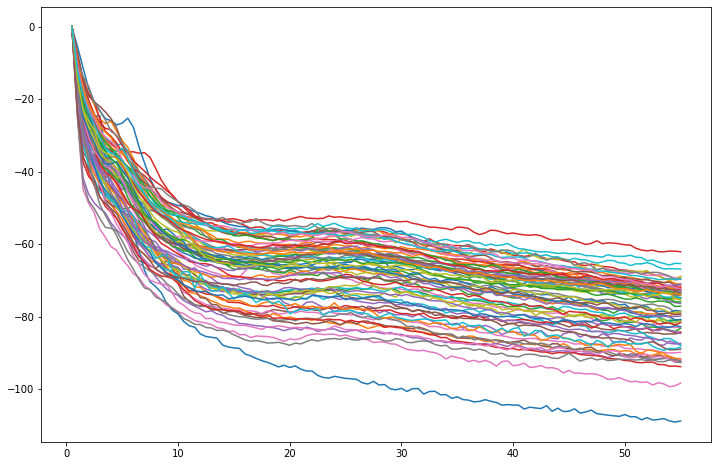

In [40]:
# Plot infant spectra

max_freq_idx = 110
plt.figure(figsize=(12, 8))

infant_psd_dict = {}
for subject in df_infant.subject_id:
    psd_file_name = '%s/%s_psd.npy' % (exp_folder, subject)
    freqs_file_name = '%s/%s_freqs.npy' % (exp_folder, subject)

    psd = np.load(psd_file_name)
    psd = psd.mean(axis=(0,1))
    freqs = np.load(freqs_file_name)

    psd_db = functions.mag2db(psd)
        
    psd_db =  scale_spectra(psd_db)
    infant_psd_dict[str(subject)] = psd_db[:max_freq_idx]
    
    # Plot the data and the interpolation
    plt.plot(freqs[:max_freq_idx], psd_db[:max_freq_idx])

plt.show();

In [60]:
# Calculate Infant posteriors
start_time = time.time()

infant_priors = {}
for subject, psd in infant_psd_dict.items():
    
    observation_summary_statistics = calculate_summary_statistics(psd)
    infant_priors[subject] = posterior.sample((1000,), x=observation_summary_statistics, show_progress_bars=0, sample_with_mcmc=1)    
    
    with open("infant_priors.pkl", 'wb') as f:
        pkl.dump(kid_priors,f)
    print("subject: %s, %.2f minutes" % (subject, (time.time() - start_time)/60))

subject: sub-01_ses-02, 10.45 minutes
subject: sub-01_ses-03, 29.44 minutes
subject: sub-01_ses-04, 41.67 minutes
subject: sub-01_ses-05, 54.25 minutes
subject: sub-02_ses-01, 69.91 minutes
subject: sub-02_ses-02, 81.98 minutes
subject: sub-02_ses-03, 99.48 minutes
subject: sub-02_ses-04, 111.06 minutes
subject: sub-02_ses-05, 125.47 minutes
subject: sub-02_ses-06, 136.18 minutes
subject: sub-03_ses-01, 150.23 minutes
subject: sub-03_ses-02, 165.02 minutes
subject: sub-03_ses-03, 177.08 minutes
subject: sub-03_ses-04, 188.94 minutes
subject: sub-03_ses-05, 208.07 minutes
subject: sub-03_ses-06, 220.24 minutes
subject: sub-04_ses-01, 230.77 minutes
subject: sub-04_ses-02, 241.25 minutes
subject: sub-04_ses-03, 255.19 minutes
subject: sub-05_ses-01, 267.85 minutes
subject: sub-05_ses-02, 282.45 minutes
subject: sub-05_ses-03, 300.44 minutes
subject: sub-06_ses-01, 313.63 minutes
subject: sub-07_ses-01, 325.16 minutes
subject: sub-09_ses-01, 336.83 minutes
subject: sub-09_ses-02, 387.80 m

In [61]:
with open("infant_priors.pkl", 'wb') as f:
    pkl.dump(infant_priors,f)

# Prepare for ages for analysis

In [196]:
curr_ages = []
curr_vals = [] 

for subject, subj_sim_vals in kid_priors.items():

    age = df_kids.loc[df_kids.subject_id == subject].age.values[0]
    
    
    curr_subj_params = []
    for row in range(dim):

        sim_vals = subj_sim_vals[:,row]
        param_ = np.mean(list(sim_vals))
        
        curr_subj_params.append(param_)
        
    curr_ages.extend([age])
    curr_vals.append(curr_subj_params)

for subject, subj_sim_vals in infant_priors.items():
    age = df_infant.loc[df_infant.subject_id == subject].age.values[0]/365.0
    
    curr_subj_params = []
    for row in range(dim):

        sim_vals = subj_sim_vals[:,row]
        param_ = np.mean(list(sim_vals))
        
        curr_subj_params.append(param_)
        
    curr_ages.extend([age])
    curr_vals.append(curr_subj_params)
        
    
    
theta_df = pd.DataFrame(curr_vals)
theta_df['Age'] = curr_ages

# theta_df = theta_df.T
# theta_df = theta_df.astype('float')
# theta_df.columns = ['Age', curr_prior]
    

# Add Toddlers

In [11]:
# Parameters
df_tots = pd.read_csv('../../../eegUCSFPedsSpectra/csv/sessions.csv')
exp_folder = '../../../eegUCSFPedsSpectra/results/psds/' # export folder
# freqs_file_name = '%s/%s_freqs.npy' % (exp_folder, df.index[0])


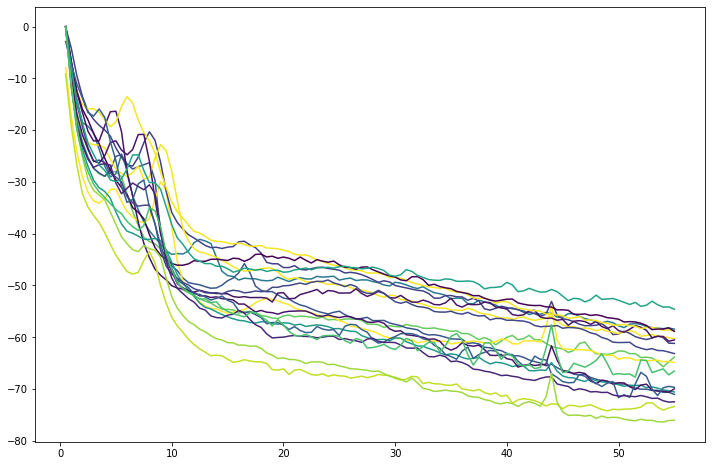

In [75]:

max_freq_idx = 110
plt.figure(figsize=(12, 8))      

cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin=np.min(df_tots.age), vmax=np.max(df_tots.age))

tots_psd_dict = {}
for subject in df_tots.subject_id:
#     print(subject)
    psd_file_name = '%s/%s_psd.npy' % (exp_folder, subject)
    freqs_file_name = '%s/%s_freqs.npy' % (exp_folder, subject)

    psd = np.load(psd_file_name)
    psd = psd.mean(axis=(0,1))
    freqs = np.load(freqs_file_name)

    psd_db = functions.mag2db(psd)
    psd_db =  scale_spectra(psd_db)
    psd=psd_db

    max_idx = np.argmax(psd[10:max_freq_idx])
    if freqs[max_idx] > 15:
        print('\tSkipping!', subject,' because of noise')
        
        df_kids = df_tots.drop(df_tots[df_tots.subject_id == subject].index)
        continue
    
    tots_psd_dict[str(subject)] = [freqs[:max_freq_idx], psd[:max_freq_idx]]
    
    
    age = df_tots.loc[df_tots.subject_id == subject].age.values[0]

    plt.plot(freqs[:max_freq_idx], psd[:max_freq_idx], color=cmap(norm(age)))
    

    
# plt.yscale('log')
# plt.xscale('log')
plt.show();

In [ ]:
# Calculate toddler posteriors

start_time = time.time()

tot_priors = {}
for subject, vals in tots_psd_dict.items():

    freqs, psd = tots_psd_dict[subject]
    
    observation_summary_statistics = calculate_summary_statistics(psd)
    tot_priors[subject] = posterior.sample((1000,), x=observation_summary_statistics, show_progress_bars=0, sample_with_mcmc=1)    
    
    with open("tot_priors.pkl", 'wb') as f:
        pkl.dump(tot_priors,f)
    print("subject: %s, %.2f minutes" % (subject, (time.time() - start_time)/60))

In [419]:

curr_ages = []
curr_vals = [] 

for subject, subj_sim_vals in kid_priors.items():

    age = df_kids.loc[df_kids.subject_id == subject].age.values[0]
    
    
    curr_subj_params = []
    for row in range(dim):

        sim_vals = subj_sim_vals[:,row]
        param_ = np.mean(list(sim_vals))
        
        curr_subj_params.append(param_)
        
    curr_ages.extend([age])
    curr_vals.append(curr_subj_params)

    
for subject, subj_sim_vals in tot_priors.items():

    age = df_tots.loc[df_tots.subject_id == int(subject)].age.values[0]/365.
    
    
    curr_subj_params = []
    for row in range(dim):

        sim_vals = subj_sim_vals[:,row]
        param_ = np.mean(list(sim_vals))
        
        curr_subj_params.append(param_)
        
    curr_ages.extend([age])
    curr_vals.append(curr_subj_params)    

    
for subject, subj_sim_vals in infant_priors.items():
    age = df_infant.loc[df_infant.subject_id == subject].age.values[0]/365.0
    
    curr_subj_params = []
    for row in range(dim):

        sim_vals = subj_sim_vals[:,row]
        param_ = np.mean(list(sim_vals))
        
        curr_subj_params.append(param_)
        
    curr_ages.extend([age])
    curr_vals.append(curr_subj_params)
        
    
    
theta_df = pd.DataFrame(curr_vals)
theta_df['Age'] = curr_ages

# theta_df = theta_df.T
# theta_df = theta_df.astype('float')
# theta_df.columns = ['Age', curr_prior]
    

In [410]:
theta_df.to_pickle("theta_df.pkl")

# Model relationship of priors to age

In [4]:
# Load saved data

with open("theta_df.pkl", "rb") as fh:
    theta_df = pkl.load(fh)


# Predict age from posteriors

In [5]:
# Select subjects < 30 years of age
theta_df = theta_df[theta_df['Age'] < 30]
X = theta_df.iloc[:,2:-1]
Y = np.log(theta_df['Age'])


In [ ]:
scaler = StandardScaler()
print(scaler.fit(X))

In [261]:
# Adjusted R2
def adjr2(r2, n, p):
    return (1 - (1 - r2) * ((n - 1) / 
          (n - p - 1)))

In [324]:
pmodel = make_pipeline(PolynomialFeatures(2), linear_model.LinearRegression())

In [325]:
# create a KFold object with 10 splits 
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
scores = cross_val_score(pmodel, scaler.transform(X), Y, scoring='neg_mean_squared_error', cv=folds)
MSE = -np.mean(scores)

train_lengths = []
for train_index, test_index in folds.split(X):
    train_lengths.append(len(train_index))
    
scores = cross_val_score(pmodel, scaler.transform(X), Y, scoring='r2', cv=folds)
adj_scores = []
for sco, lens in zip(scores,train_lengths):
    adj_scores.append(adjr2(sco, lens, 4))
r2 = np.mean(adj_scores)

preds = cross_val_predict(pmodel, scaler.transform(X), Y,  cv=folds)

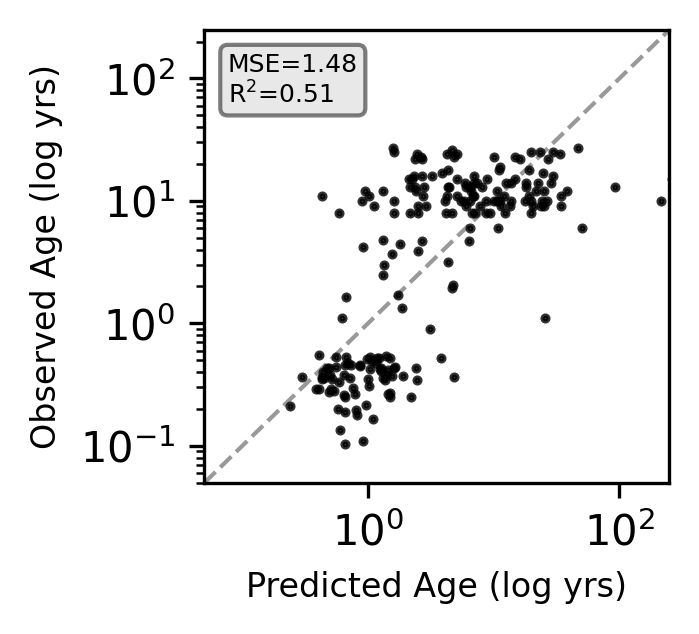

In [326]:
plt.figure(figsize=(2,2), dpi=300)
plt.scatter(np.exp(preds), np.exp(Y),   s=2, color='black', alpha=0.8)


plt.ylim([0.05,250])
plt.xlim([0.05,250])

plt.yscale('log', )
plt.xscale('log', )
ax.set_aspect('equal')


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax=plt.gca()

# now plot both limits against eachother
ax.plot(lims, lims, 'k--', linewidth=1, alpha=0.4, zorder=0)

plt.ylabel('Observed Age (log yrs)', fontsize=8);
plt.xlabel('Predicted Age (log yrs)', fontsize=8)


textstr = '\n'.join((
    r'MSE=%.2f' % (MSE, ),
    r'$\mathregular{R^2}$=%.2f' % (r2, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='lightgray', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=6,
        verticalalignment='top', bbox=props)

plt.savefig('Fig6_predAge_polyreg_KF10.png', bbox_inches='tight');

In [7]:
# Load saved data   
with open("infant_priors.pkl", 'rb') as f:
    infant_priors = pkl.load(f)
    
with open("tot_priors.pkl", 'rb') as f:
    tot_priors = pkl.load(f)
    
with open("kid_priors.pkl", 'rb') as f:
    kid_priors = pkl.load(f)

# Plot Thetas vs Age Log scale X-axis (Age)

$\alpha$ (0.2838670458525141, 3.880579234782316e-05)
$\mathrm{S}$ (0.3496044560052325, 2.97027922214345e-07)
$\mathrm{G}_{EI}$ (-0.42984300519260804, 1.3997289430987092e-10)
$\mathrm{G}_{II}$ (-0.04953645561369265, 0.48167777386361277)


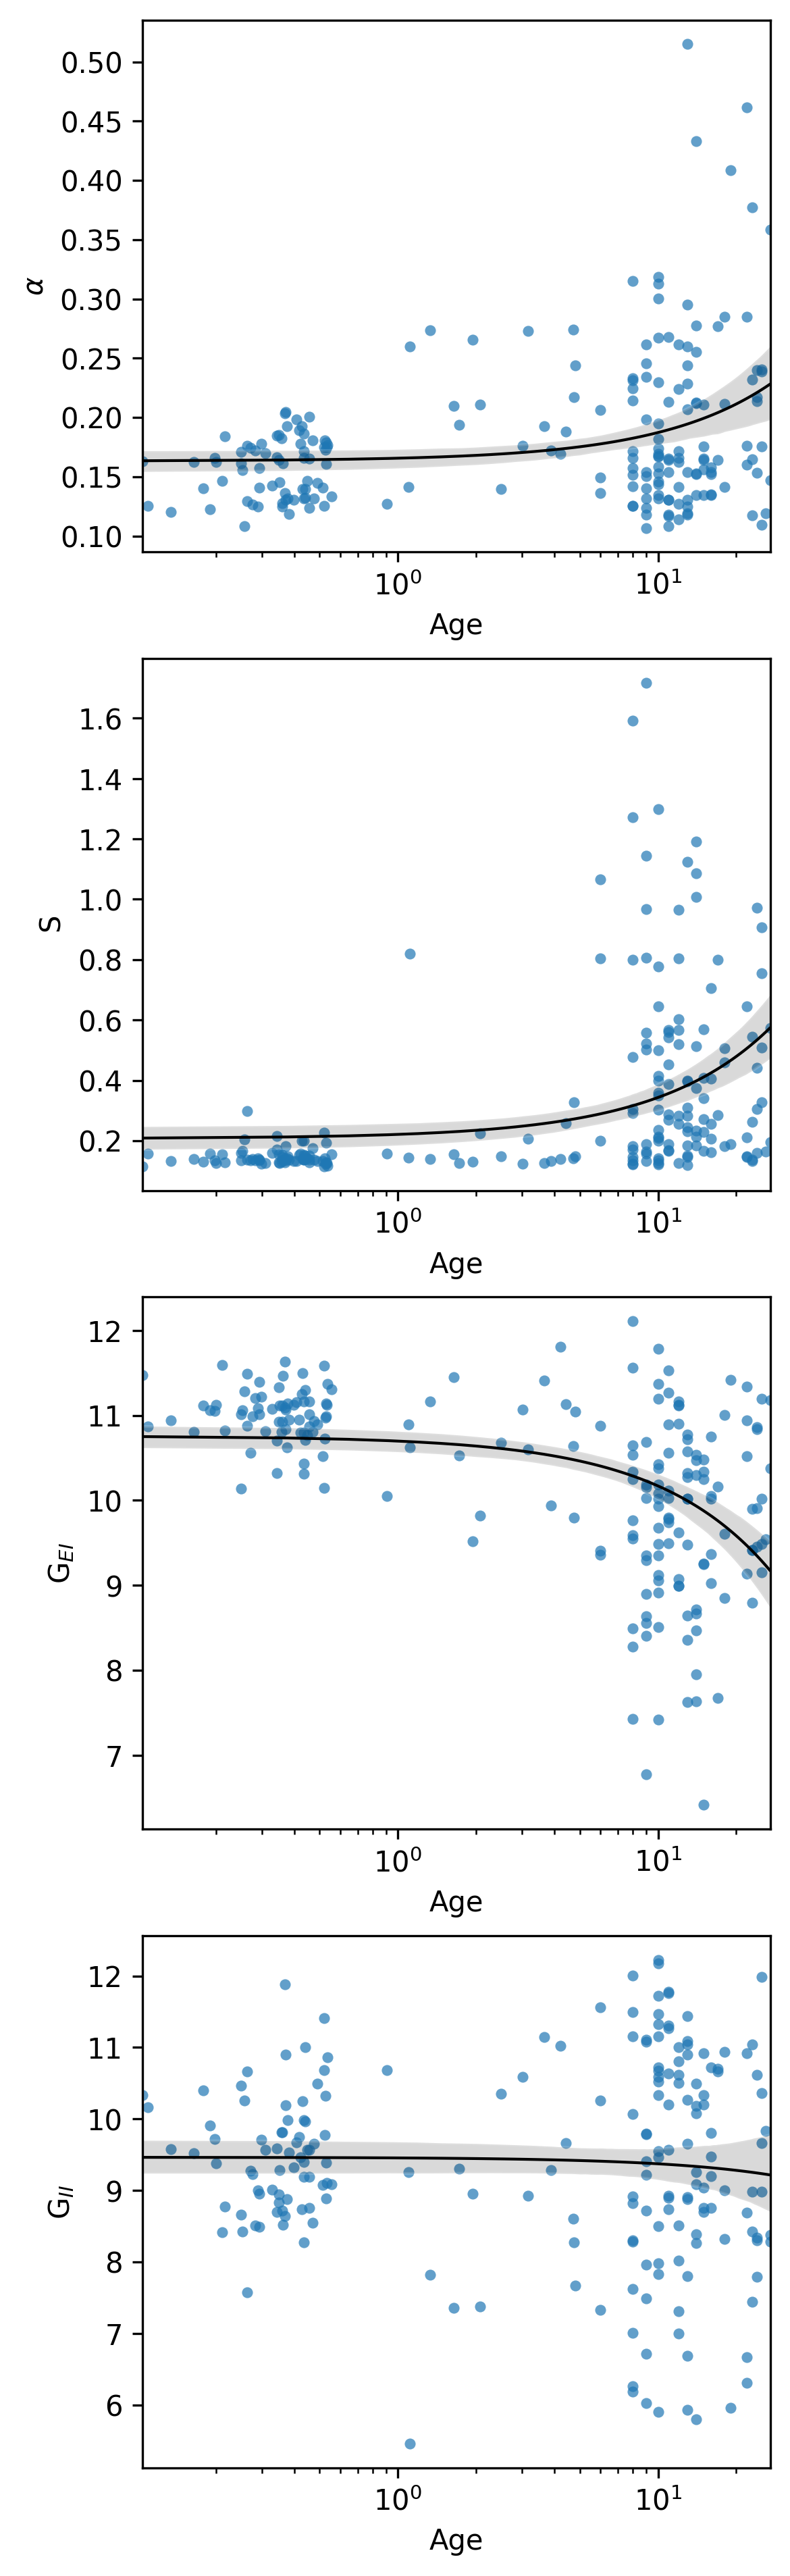

In [24]:
labels=[r'$\tau_e$', r'$\tau_i$', r'$\alpha$', r'$\mathrm{S}$', r'$\mathrm{G}_{EI}$', r'$\mathrm{G}_{II}$', r'$\tau_\mathrm{G}$']

dim = 6
fig,ax=plt.subplots(4,1, figsize=(4,16), dpi=300)
for idx in range(4):
    
    row = idx+2
    curr_prior = labels[row]
    
    curr_ages = []
    curr_vals = []    
    
    for subject, curr in infant_priors.items():
        
        age = df_infant.loc[df_infant.subject_id == subject].age.values[0]/365.0
        sim_vals = curr[:,row]
        param_ = np.mean(list(sim_vals))
        curr_ages.extend([age])
        curr_vals.append(param_)

    for subject, curr in tot_priors.items():
        
        age = df_tots.loc[df_tots.subject_id == int(subject)].age.values[0]/365.0
        sim_vals = curr[:,row]
        param_ = np.mean(list(sim_vals))
        curr_ages.extend([age])
        curr_vals.append(param_)
                
        
    for subject, curr in kid_priors.items():
        age = df_kids.loc[df_kids.subject_id == subject].age.values[0]
        sim_vals = curr[:,row]
        param_ = np.mean(list(sim_vals))
        curr_ages.extend([age])
        curr_vals.append(param_)
        

    
    theta_df = pd.DataFrame([curr_ages, curr_vals])
    theta_df = theta_df.T
    theta_df = theta_df.astype('float')
    theta_df.columns = ['Age', curr_prior]
    
    # Select age < 30 
    theta_df = theta_df[theta_df['Age'] < 30]
    
    with sns.axes_style("whitegrid"):

        sns.regplot(x='Age', y=labels[row], data=theta_df, fit_reg=True, ax=ax[idx], 
                    line_kws={"color": "black","linewidth":1}, scatter_kws={"linewidth":0, "s":15, "alpha":0.7}
                    );

   
    ax[idx].set(ylabel=labels[row])
    ax[idx].set_xscale('log')

    curr_pearsonr = stats.pearsonr(theta_df.Age, theta_df[curr_prior])
    print(labels[row], curr_pearsonr)

plt.savefig("Fig_predSGMparams_log.svg", format="svg",transparent=True)  
# plt.savefig('Fig_predSGMparams_log.png', bbox_inches='tight');

# Plot Linear Thetas vs Age

$\alpha$ (0.2838670458525141, 3.880579234782316e-05)
$\mathrm{S}$ (0.3496044560052325, 2.97027922214345e-07)
$\mathrm{G}_{EI}$ (-0.42984300519260804, 1.3997289430987092e-10)
$\mathrm{G}_{II}$ (-0.04953645561369265, 0.48167777386361277)


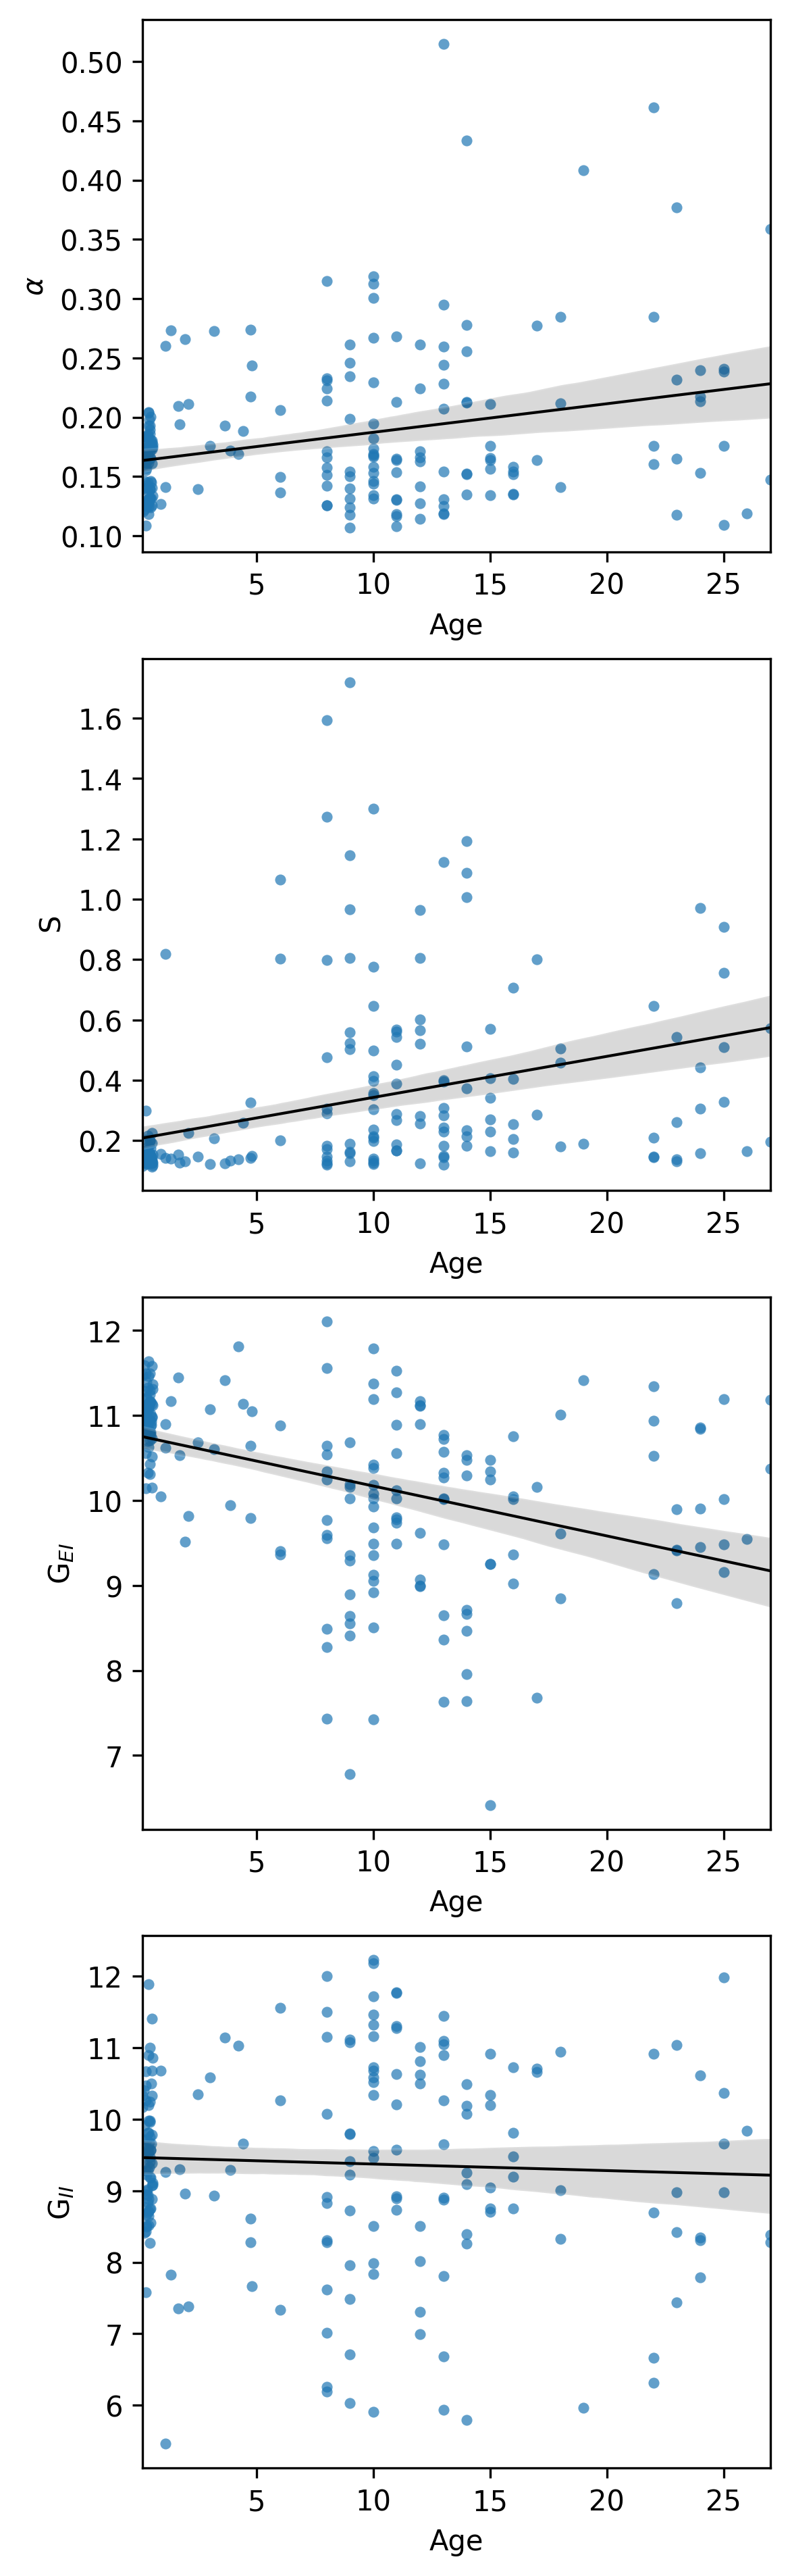

In [25]:
labels=[r'$\tau_e$', r'$\tau_i$', r'$\alpha$', r'$\mathrm{S}$', r'$\mathrm{G}_{EI}$', r'$\mathrm{G}_{II}$', r'$\tau_\mathrm{G}$']

dim = 6
fig,ax=plt.subplots(4,1, figsize=(4,16), dpi=300)
for idx in range(4):
    
    row = idx+2
    curr_prior = labels[row]
    
    curr_ages = []
    curr_vals = []    
    
    for subject, curr in infant_priors.items():
        
        age = df_infant.loc[df_infant.subject_id == subject].age.values[0]/365.0
        sim_vals = curr[:,row]
        param_ = np.mean(list(sim_vals))
        curr_ages.extend([age])
        curr_vals.append(param_)

    for subject, curr in tot_priors.items():
        
        age = df_tots.loc[df_tots.subject_id == int(subject)].age.values[0]/365.0
        sim_vals = curr[:,row]
        param_ = np.mean(list(sim_vals))
        curr_ages.extend([age])
        curr_vals.append(param_)
                
        
    for subject, curr in kid_priors.items():
        age = df_kids.loc[df_kids.subject_id == subject].age.values[0]
        sim_vals = curr[:,row]
        param_ = np.mean(list(sim_vals))
        curr_ages.extend([age])
        curr_vals.append(param_)
        

    
    theta_df = pd.DataFrame([curr_ages, curr_vals])
    theta_df = theta_df.T
    theta_df = theta_df.astype('float')
    theta_df.columns = ['Age', curr_prior]
    
    # Select age < 30 
    theta_df = theta_df[theta_df['Age'] < 30]
    
    with sns.axes_style("whitegrid"):

        sns.regplot(x='Age', y=labels[row], data=theta_df, fit_reg=True, ax=ax[idx], 
                    line_kws={"color": "black","linewidth":1}, scatter_kws={"linewidth":0, "s":15, "alpha":0.7}
                    );

   
    ax[idx].set(ylabel=labels[row])
    

    
    curr_pearsonr = stats.pearsonr(theta_df.Age, theta_df[curr_prior])
    print(labels[row], curr_pearsonr)

plt.savefig("Fig_predSGMparams_linear.svg", format="svg",transparent=True)  
# plt.savefig('Fig_predSGMparams_linear.png', bbox_inches='tight');

In [109]:
thetas_valid_df = pd.DataFrame(thetas_valid)

In [115]:
# Select thetas with valid detected aperiodic exponent and pdr
thetas_valid_df_sel = thetas_valid_df[thetas_valid_df[4] == 1]

In [120]:
# Select thetas with age < 30
np.array(fooof_df['Age'] < 30).shape

(188,)

In [122]:
thetas_valid_df_sel = thetas_valid_df_sel[np.array(fooof_df['Age'] < 30)]

In [123]:
fooof_df_sel = fooof_df[np.array(fooof_df['Age'] < 30)]

In [329]:
X = thetas_valid_df_sel.iloc[:, :-1]
Y = fooof_df_sel.pdr

scaler = StandardScaler()
print(scaler.fit(X))


StandardScaler()


In [330]:
pmodel = make_pipeline(PolynomialFeatures(2), linear_model.LinearRegression())

In [333]:
# create a KFold object with 10 splits 
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
scores = cross_val_score(pmodel, scaler.transform(X), Y, scoring='neg_mean_squared_error', cv=folds)
MSE = -np.mean(scores)

train_lengths = []
for train_index, test_index in folds.split(X):
    train_lengths.append(len(train_index))

scores = cross_val_score(pmodel, scaler.transform(X), Y, scoring='r2', cv=folds)
adj_scores = []
for sco, lens in zip(scores,train_lengths):
    adj_scores.append(adjr2(sco, lens, 4))
r2 = np.mean(adj_scores)


preds = cross_val_predict(pmodel, scaler.transform(X), Y,  cv=folds)

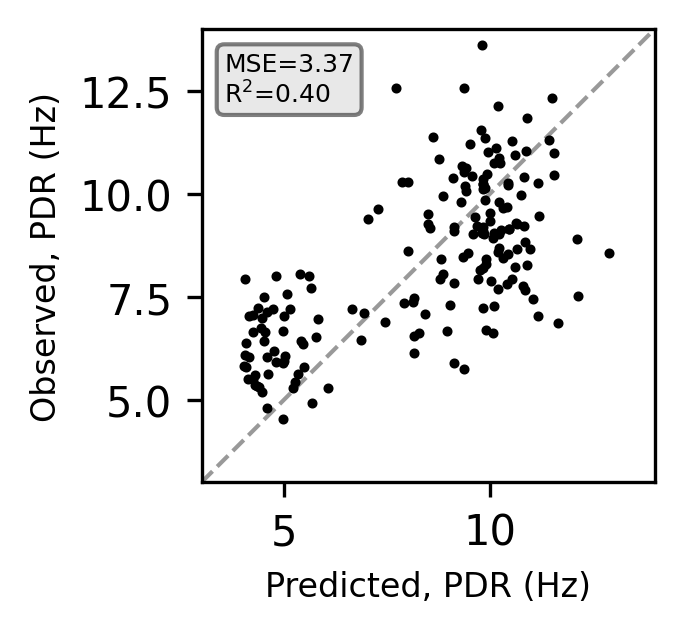

In [334]:
plt.figure(figsize=(2,2), dpi=300)
plt.scatter(Y, preds, s=2, color='black', alpha=1)

plt.ylabel('Observed, PDR (Hz)', fontsize=8);
plt.xlabel('Predicted, PDR (Hz)', fontsize=8);

plt.ylim([3.,14])
plt.xlim([3.,14])
ax.set_aspect('equal')

ax = plt.gca()
ax.set_aspect('equal')


# y_ticks = np.arange(2, 14, 4)
# plt.yticks(y_ticks, fontsize=8)
# plt.xticks(y_ticks, fontsize=8)
ax.set_aspect('equal')


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax=plt.gca()

# now plot both limits against eachother
ax.plot(lims, lims, 'k--', linewidth=1, alpha=0.4, zorder=0)
textstr = '\n'.join((
    r'MSE=%.2f' % (MSE, ),
    r'$\mathregular{R^2}$=%.2f' % (r2, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='lightgray', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=6,
        verticalalignment='top', bbox=props)


plt.savefig('Fig6_predPDR_fooof_KF10.png', bbox_inches='tight');

# Predict Aperiodic Exponent

In [335]:
X = thetas_valid_df_sel.iloc[:, :-1]
Y = fooof_df_sel.ap_exp

scaler = StandardScaler()
print(scaler.fit(X))

pmodel = make_pipeline(PolynomialFeatures(2), linear_model.LinearRegression())


StandardScaler()


In [339]:
# create a KFold object with 10 splits 
folds = KFold(n_splits = 10, shuffle = True, random_state = 100)
scores = cross_val_score(pmodel, scaler.transform(X), Y, scoring='neg_mean_squared_error', cv=folds)
MSE = -np.mean(scores)

train_lengths = []
for train_index, test_index in folds.split(X):
    train_lengths.append(len(train_index))
    
scores = cross_val_score(pmodel, scaler.transform(X), Y, scoring='r2', cv=folds)
adj_scores = []
for sco, lens in zip(scores,train_lengths):
    adj_scores.append(adjr2(sco, lens, 4))
r2 = np.mean(adj_scores)

preds = cross_val_predict(pmodel, scaler.transform(X), Y,  cv=folds)

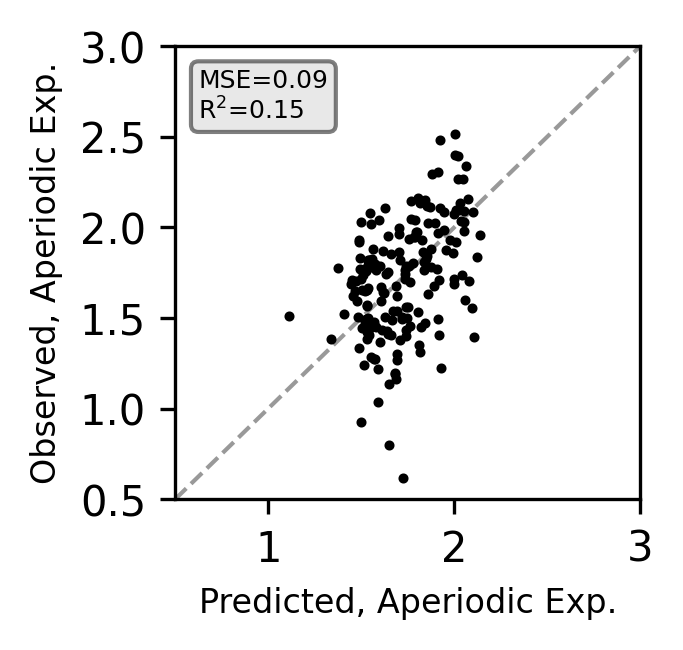

In [340]:
plt.figure(figsize=(2,2), dpi=300)
plt.scatter(preds, Y, s=2, color='black', alpha=1)

plt.ylabel('Observed, Aperiodic Exp.', fontsize=8);
plt.xlabel('Predicted, Aperiodic Exp.', fontsize=8);

plt.ylim([.5,3])
plt.xlim([.5,3])
ax.set_aspect('equal')

# ax = plt.gca()
# ax.set_aspect('equal')


# y_ticks = np.arange(4, 16, 4)
# plt.yticks(y_ticks, fontsize=6)
# plt.xticks(y_ticks, fontsize=6)
# ax.set_aspect('equal')


lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax=plt.gca()

# now plot both limits against eachother
ax.plot(lims, lims, 'k--', linewidth=1, alpha=0.4, zorder=0)



textstr = '\n'.join((
    r'MSE=%.2f' % (MSE, ),
    r'$\mathregular{R^2}$=%.2f' % (r2, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='lightgray', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=6,
        verticalalignment='top', bbox=props)



plt.savefig('Fig6_predAP_fooof_KF10.png', bbox_inches='tight');